In [1]:
import torch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn.functional as F

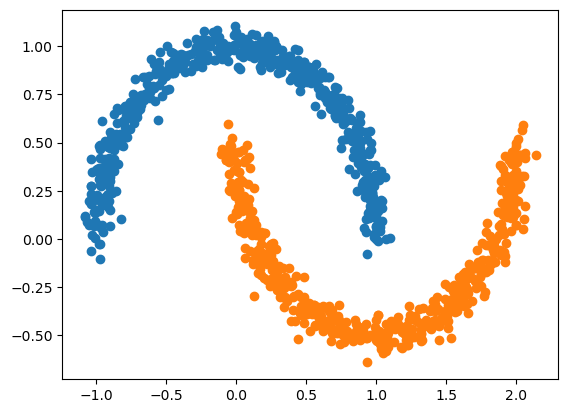

In [2]:
from sklearn import cluster, datasets, mixture
X, y = datasets.make_moons(n_samples=1024, noise=0.05)
for i in range(2):
    mask = y == i
    plt.scatter(X[mask, 0], X[mask, 1])

# Unconditional

In [3]:
from zzhuang_ops.loggerx import LoggerXBase

logger = LoggerXBase(save_root=None, print_freq=100)

from easydict import EasyDict
cfg = EasyDict()
cfg.layers = 10
# cfg.t0= 0
# cfg.t1= 1
# cfg.stepsize= 0.1
# cfg.solver= 'dopri5'
# cfg.backprop= 'adjoint'
# cfg.trace= 'hutchinson'
from zzhuang_ops.nn.flows import MAF, Glow, Ffjord, Flowpp, RealNVP, ResFlow, PlanarFlow

networks = {
    'planar': PlanarFlow,
    'realnvp': RealNVP,
    'glow': Glow,
    'flow++': Flowpp,
    'maf': MAF,
    'resflow': ResFlow,
    'ffjord': Ffjord,
}
# model_name = 'ffjord'
model_name = 'realnvp'
model = networks[model_name]([2, ], cfg=cfg).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
max_iter = 10000
for n_iter in range(max_iter):
    model.train()
    X, y = datasets.make_moons(n_samples=256, noise=0.05)
    X = torch.from_numpy(X).float().cuda()
    z, log_det_jacobian = model(X)
    z = z.view(X.size(0), -1)
    loss = -1.0 * torch.mean(D.Normal(0, 1).log_prob(z).sum(dim=1) + log_det_jacobian)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    logger.msg([loss, log_det_jacobian], n_iter)

[11-19 15:45:05] 00000, loss 2.4168601, log_det_jacobian 0.6050144, 
[11-19 15:45:15] 00100, loss 1.5543425, log_det_jacobian 1.1865300, 
[11-19 15:45:24] 00200, loss 1.1461433, log_det_jacobian 1.5515627, 
[11-19 15:45:34] 00300, loss 1.0445513, log_det_jacobian 1.6661479, 
[11-19 15:45:43] 00400, loss 0.9731154, log_det_jacobian 1.7508264, 
[11-19 15:45:53] 00500, loss 0.9728516, log_det_jacobian 1.7660942, 
[11-19 15:46:02] 00600, loss 0.9220180, log_det_jacobian 1.8374066, 
[11-19 15:46:12] 00700, loss 0.8836216, log_det_jacobian 1.8857604, 
[11-19 15:46:22] 00800, loss 0.8740665, log_det_jacobian 1.8959280, 
[11-19 15:46:31] 00900, loss 0.8532060, log_det_jacobian 1.9233818, 
[11-19 15:46:41] 01000, loss 0.9018867, log_det_jacobian 1.8814049, 
[11-19 15:46:50] 01100, loss 0.8076232, log_det_jacobian 1.9547115, 
[11-19 15:47:00] 01200, loss 0.8250891, log_det_jacobian 1.9693271, 
[11-19 15:47:09] 01300, loss 0.8588384, log_det_jacobian 1.9528484, 
[11-19 15:47:19] 01400, loss 0.775

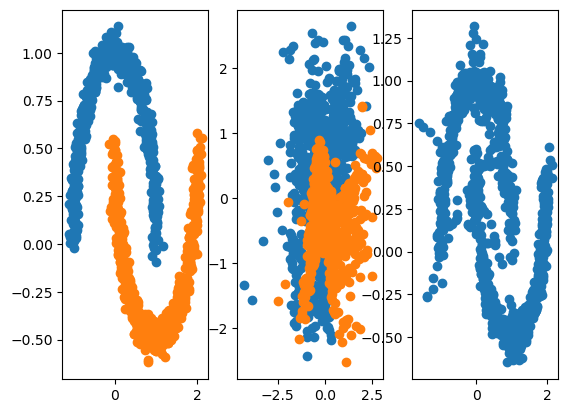

In [7]:
model.eval()
with torch.no_grad():
    X, y = datasets.make_moons(n_samples=1024, noise=0.05)
    z, log_det_jacobian = model(torch.from_numpy(X).float().cuda())
    z = z.cpu().numpy()
for j, data in enumerate([X, z]):
    plt.subplot(1, 3, j + 1)
    for i in range(2):
        mask = y == i
        plt.scatter(data[mask, 0], data[mask, 1])
plt.subplot(1, 3, 3)
with torch.no_grad():
    new_X, log_det_jacobians = model.backward(torch.randn(1024, 2).float().cuda())
    new_X = new_X.cpu().numpy()
plt.scatter(new_X[:, 0], new_X[:, 1])

# Conditional

In [4]:
from zzhuang_ops.loggerx import LoggerXBase

logger = LoggerXBase(save_root=None, print_freq=100)

from zzhuang_ops.nn.flows.conditional_realnvp import ConditionalRealNVP

model = ConditionalRealNVP(2, 2, 10).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
max_iter = 10000
for n_iter in range(max_iter):
    model.train()
    X, y = datasets.make_moons(n_samples=256, noise=0.05)
    X = torch.from_numpy(X).float().cuda()
    # y = torch.from_numpy(y).float().cuda()
    y = F.one_hot(torch.from_numpy(y).long(), 2).float().cuda()
    z, log_det_jacobian = model(X, y)
    z = z.view(X.size(0), -1)
    logp = D.Normal(0, 1).log_prob(z).sum(dim=1)
    loss = -1.0 * torch.mean(logp + log_det_jacobian)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    logger.msg([loss, logp, log_det_jacobian], n_iter)

[11-23 06:45:13] 00000, loss 2.6562490, logp -3.0327168, log_det_jacobian 0.3764677, 
[11-23 06:45:24] 00100, loss 0.9507104, logp -2.7666904, log_det_jacobian 1.8159800, 
[11-23 06:45:34] 00200, loss -0.0840899, logp -2.7060174, log_det_jacobian 2.7901073, 
[11-23 06:45:44] 00300, loss -0.2263215, logp -2.7400641, log_det_jacobian 2.9663856, 
[11-23 06:45:55] 00400, loss -0.2664297, logp -2.7737725, log_det_jacobian 3.0402022, 
[11-23 06:46:05] 00500, loss -0.2905513, logp -2.7903961, log_det_jacobian 3.0809474, 
[11-23 06:46:15] 00600, loss -0.2904727, logp -2.7970827, log_det_jacobian 3.0875555, 
[11-23 06:46:25] 00700, loss -0.3050990, logp -2.8057931, log_det_jacobian 3.1108922, 
[11-23 06:46:35] 00800, loss -0.3092873, logp -2.8119782, log_det_jacobian 3.1212654, 
[11-23 06:46:45] 00900, loss -0.3090136, logp -2.8198513, log_det_jacobian 3.1288649, 
[11-23 06:46:56] 01000, loss -0.3118146, logp -2.8225767, log_det_jacobian 3.1343913, 
[11-23 06:47:06] 01100, loss -0.3214166, logp

KeyboardInterrupt: 

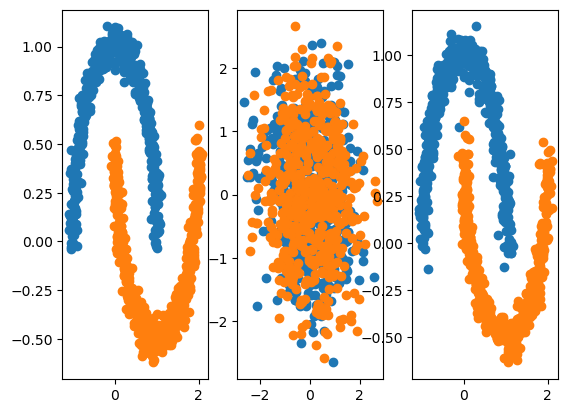

In [6]:
model.eval()
with torch.no_grad():
    X, y = datasets.make_moons(n_samples=1024, noise=0.05)
    z, log_det_jacobian = model(torch.from_numpy(X).float().cuda(),
                                F.one_hot(torch.from_numpy(y).long(), 2).float().cuda())
    z = z.cpu().numpy()
for j, data in enumerate([X, z]):
    plt.subplot(1, 3, j + 1)
    for i in range(2):
        mask = y == i
        plt.scatter(data[mask, 0], data[mask, 1])
plt.subplot(1, 3, 3)
with torch.no_grad():
    y = torch.randint(0, 2, (1024, )).numpy()
    new_X, log_det_jacobians = model.backward(torch.randn(1024, 2).float().cuda(),
                                              F.one_hot(torch.from_numpy(y).long(), 2).float().cuda())
    new_X = new_X.cpu().numpy()
    for i in range(2):
        mask = y == i
        plt.scatter(new_X[mask, 0], new_X[mask, 1])
# plt.scatter(new_X[:, 0], new_X[:, 1])